## 1. Environment Setup and Package Installation\

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import os
from datetime import datetime
from tqdm import tqdm
from pathlib import Path


## 2. Data Loading

In [49]:
DATA_DIR = Path("data")
CSV_DIR = DATA_DIR / "csv"
REVIEWS_DIR = DATA_DIR / "reviews"
LAPTOPS_CSV = CSV_DIR / "gaming_laptops_with_reviews.csv"

# Create directories if they don't exist
os.makedirs("./data/processed", exist_ok=True)

In [50]:
# Load the laptop data from CSV
def load_laptop_data(csv_path):
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} laptops from {csv_path}")
        return df
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return pd.DataFrame()

# Load reviews from JSON files
def load_review_data(directory):
    all_reviews = []
    
    # List all JSON files in the directory
    json_files = [f for f in os.listdir(directory) if f.endswith('.json')]
    
    for file_name in tqdm(json_files, desc="Loading review files"):
        file_path = os.path.join(directory, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                review_data = json.load(file)
                all_reviews.extend(review_data)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return all_reviews

In [51]:
# Load the data
products_df = load_laptop_data(LAPTOPS_CSV)
reviews = load_review_data(REVIEWS_DIR)
reviews_df = pd.DataFrame(reviews)

Loaded 254 laptops from data/csv/gaming_laptops_with_reviews.csv


Loading review files: 100% 254/254 [00:00<00:00, 8055.66it/s]


In [52]:
# Display basic information
print(f"Loaded {len(products_df)} products and {len(reviews_df)} reviews")
print("\nProduct DataFrame Info:")
products_df.info()
print("\nReviews DataFrame Info:")
reviews_df.info()

Loaded 254 products and 1270 reviews

Product DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   laptop_name  254 non-null    object 
 1   price        253 non-null    float64
 2   brand_name   254 non-null    object 
 3   rating       254 non-null    object 
 4   num_to_rate  254 non-null    int64  
 5   shiping      254 non-null    object 
 6   save_prec    117 non-null    object 
 7   touch        254 non-null    int64  
 8   display      236 non-null    object 
 9   processor    249 non-null    object 
 10  gpu          233 non-null    object 
 11  hdd          104 non-null    object 
 12  ssd          178 non-null    object 
 13  reviews      254 non-null    object 
dtypes: float64(1), int64(2), object(11)
memory usage: 27.9+ KB

Reviews DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 126

## 3. Data Cleaning and Transformation

In [53]:
# Print the column names to see what's available
print("Available columns in the CSV file:")
print(products_df.columns.tolist())

# Display the first few rows to understand the data structure
print("\nSample data:")
display(products_df.head())

Available columns in the CSV file:
['laptop_name', 'price', 'brand_name', 'rating', 'num_to_rate', 'shiping', 'save_prec', 'touch', 'display', 'processor', 'gpu', 'hdd', 'ssd', 'reviews']

Sample data:


,laptop_name,price,brand_name,rating,num_to_rate,shiping,save_prec,touch,display,processor,gpu,hdd,ssd,reviews
0,"GIGABYTE AERO 15-X9-9RT4K5MP 15.6"" 4K/UHD IPS ...",3099.0,GIGABYTE,Rating + 4,363,Free Shipping,NaN,0,"15.6""",i9,RTX 2070,NaN,1 TB SSD,data\reviews\laptop_0_reviews.json
1,"Lenovo Y50 Touch (59426255) 15.6"" Intel Core i...",1684.0,Lenovo,Rating + 3,186,Free Shipping,NaN,1,"15.6""",i7,GTX 860,1 TB HDD,8 GB SSD,data\reviews\laptop_1_reviews.json
2,MSI GP63 Leopard-013 Gaming Laptop GTX 1060 6 ...,1530.0,MSI,Rating + 4,156,Free Shipping,NaN,0,"15.6""",i7,GTX 1060,NaN,NaN,data\reviews\laptop_2_reviews.json
3,MSI GS Series GS65 Stealth THIN-053 Gaming Lap...,2499.0,MSI,Rating + 4,155,Free Shipping,NaN,0,"15.6""",i7,GTX 1070,NaN,NaN,data\reviews\laptop_3_reviews.json
4,Acer Aspire V15 Nitro Black Edition VN7-591G-7...,895.0,Acer America,Rating + 4,100,Free Shipping,NaN,0,"15.6""",i7,GTX 960,1 TB HDD,NaN,data\reviews\laptop_4_reviews.json


In [54]:
# Clean product data
def clean_product_data(df):
    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Handle price column - check if it's already numeric
    if 'price' in cleaned_df.columns:
        if not pd.api.types.is_numeric_dtype(cleaned_df['price']):
            # Convert price from string to numeric if it's a string
            cleaned_df['price'] = pd.to_numeric(
                cleaned_df['price'].astype(str).str.replace('$', '').str.replace(',', ''), 
                errors='coerce'
            )
    
    # Determine which column contains specifications
    spec_column = None
    possible_spec_columns = ['specifications', 'specs', 'description', 'details']
    for col in possible_spec_columns:
        if col in cleaned_df.columns:
            spec_column = col
            break
    
    # If we found a specifications column, extract features
    if spec_column:
        # Extract processor information
        def extract_processor(specs):
            if not isinstance(specs, str):
                return None
            processor_patterns = [r'Intel\s+Core\s+i\d+[\-\s]\w+', r'AMD\s+Ryzen\s+\d+\s+\w+']
            for pattern in processor_patterns:
                match = re.search(pattern, specs, re.IGNORECASE)
                if match:
                    return match.group(0)
            return None
        
        # Extract GPU information
        def extract_gpu(specs):
            if not isinstance(specs, str):
                return None
            gpu_patterns = [r'NVIDIA\s+GeForce\s+RTX\s+\d+\w*', r'AMD\s+Radeon\s+\w+\s+\d+\w*']
            for pattern in gpu_patterns:
                match = re.search(pattern, specs, re.IGNORECASE)
                if match:
                    return match.group(0)
            return None
        
        # Extract RAM information
        def extract_ram(specs):
            if not isinstance(specs, str):
                return None
            ram_pattern = r'\b(\d+)\s*GB\s+RAM\b'
            match = re.search(ram_pattern, specs, re.IGNORECASE)
            if match:
                return int(match.group(1))
            return None
        
        # Extract storage information
        def extract_storage(specs):
            if not isinstance(specs, str):
                return None
            storage_pattern = r'\b(\d+)\s*(TB|GB)\s+SSD\b'
            match = re.search(storage_pattern, specs, re.IGNORECASE)
            if match:
                size = int(match.group(1))
                unit = match.group(2).upper()
                if unit == 'TB':
                    return size * 1000  # Convert TB to GB
                return size
            return None
        
        # Apply extraction functions
        cleaned_df['processor'] = cleaned_df[spec_column].apply(extract_processor)
        cleaned_df['gpu'] = cleaned_df[spec_column].apply(extract_gpu)
        cleaned_df['ram_gb'] = cleaned_df[spec_column].apply(extract_ram)
        cleaned_df['storage_gb'] = cleaned_df[spec_column].apply(extract_storage)
    else:
        # If no specification column found, check if these columns already exist
        print("No specifications column found. Using existing columns if available.")
        for col in ['processor', 'gpu', 'ram_gb', 'storage_gb']:
            if col not in cleaned_df.columns:
                cleaned_df[col] = None
    
    # Determine name column
    name_column = 'name' if 'name' in cleaned_df.columns else 'laptop_name' if 'laptop_name' in cleaned_df.columns else None
    
    # Extract brand from name if name column exists
    if name_column:
        def extract_brand(name):
            if not isinstance(name, str):
                return None
            common_brands = ['Acer', 'ASUS', 'Dell', 'HP', 'Lenovo', 'MSI', 'Razer', 'Alienware', 'Gigabyte']
            for brand in common_brands:
                if brand.lower() in name.lower():
                    return brand
            return 'Other'
        
        cleaned_df['brand'] = cleaned_df[name_column].apply(extract_brand)
    else:
        # If no name column, check if brand column already exists
        if 'brand' not in cleaned_df.columns:
            cleaned_df['brand'] = 'Unknown'
    
    return cleaned_df

    # Clean review data
def clean_review_data(df):
    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Convert rating to numeric if it exists
    if 'rating' in cleaned_df.columns:
        cleaned_df['rating'] = pd.to_numeric(cleaned_df['rating'], errors='coerce')
    
    # Clean review text
    def clean_text(text):
        if not isinstance(text, str):
            return ""
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', ' ', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    # Apply text cleaning to the 'text' column if it exists
    if 'text' in cleaned_df.columns:
        cleaned_df['cleaned_text'] = cleaned_df['text'].apply(clean_text)
        # Add review length as a feature
        cleaned_df['review_length'] = cleaned_df['cleaned_text'].apply(len)
    
    return cleaned_df

In [55]:
# Apply cleaning functions
cleaned_products_df = clean_product_data(products_df)
cleaned_reviews_df = clean_review_data(reviews_df)

# Display sample of cleaned data
print("Cleaned Products Sample:")
display(cleaned_products_df.head())
print("\nCleaned Reviews Sample:")
display(cleaned_reviews_df.head())

No specifications column found. Using existing columns if available.
Cleaned Products Sample:


,laptop_name,price,brand_name,rating,num_to_rate,shiping,save_prec,touch,display,processor,gpu,hdd,ssd,reviews,ram_gb,storage_gb,brand
0,"GIGABYTE AERO 15-X9-9RT4K5MP 15.6"" 4K/UHD IPS ...",3099.0,GIGABYTE,Rating + 4,363,Free Shipping,NaN,0,"15.6""",i9,RTX 2070,NaN,1 TB SSD,data\reviews\laptop_0_reviews.json,None,None,Gigabyte
1,"Lenovo Y50 Touch (59426255) 15.6"" Intel Core i...",1684.0,Lenovo,Rating + 3,186,Free Shipping,NaN,1,"15.6""",i7,GTX 860,1 TB HDD,8 GB SSD,data\reviews\laptop_1_reviews.json,None,None,Lenovo
2,MSI GP63 Leopard-013 Gaming Laptop GTX 1060 6 ...,1530.0,MSI,Rating + 4,156,Free Shipping,NaN,0,"15.6""",i7,GTX 1060,NaN,NaN,data\reviews\laptop_2_reviews.json,None,None,MSI
3,MSI GS Series GS65 Stealth THIN-053 Gaming Lap...,2499.0,MSI,Rating + 4,155,Free Shipping,NaN,0,"15.6""",i7,GTX 1070,NaN,NaN,data\reviews\laptop_3_reviews.json,None,None,MSI
4,Acer Aspire V15 Nitro Black Edition VN7-591G-7...,895.0,Acer America,Rating + 4,100,Free Shipping,NaN,0,"15.6""",i7,GTX 960,1 TB HDD,NaN,data\reviews\laptop_4_reviews.json,None,None,Acer



Cleaned Reviews Sample:


,review_id,rating,text,date,cleaned_text,review_length
0,laptop_142_review_1,5,Absolutely love this laptop! The performance f...,2025-3-23,Absolutely love this laptop The performance fo...,442
1,laptop_142_review_2,5,Fantastic gaming laptop for the price. Getting...,2025-3-23,Fantastic gaming laptop for the price Getting ...,353
2,laptop_142_review_3,5,Exceeded my expectations! Perfect for gaming. ...,2025-2-8,Exceeded my expectations Perfect for gaming Th...,344
3,laptop_142_review_4,4,Absolutely love this laptop! The performance f...,2025-3-14,Absolutely love this laptop The performance fo...,430
4,laptop_142_review_5,4,Absolutely love this laptop! The performance f...,2025-1-16,Absolutely love this laptop The performance fo...,439


## 4. Feature Engineering

In [56]:
# Add price categories
pd.set_option('future.no_silent_downcasting', True)
def add_price_categories(df):
    df = df.copy()
    
    # Define price ranges
    bins = [0, 800, 1200, 1800, 2500, float('inf')]
    labels = ['Budget', 'Entry', 'Mid-range', 'High-end', 'Premium']
    
    # Create price category column
    df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels)
    
    return df

# Add performance score based on specs
def add_performance_score(df):
    df = df.copy()
    
    # Create GPU tier/score based on model series
    for idx, gpu in enumerate(df['gpu']):
        if pd.isna(gpu):
            continue
        if 'RTX' in gpu:
            df.loc[idx, 'gpu_tier'] = 3
        elif 'GTX 10' in gpu or 'GTX 16' in gpu: 
            df.loc[idx, 'gpu_tier'] = 2
        elif 'GTX' in gpu:
            df.loc[idx, 'gpu_tier'] = 1
    
    # Convert tiers to scores for visualization
    tier_to_score = {0: 30, 1: 50, 2: 70, 3: 90}
    df['gpu_score'] = df['gpu_tier'].map(tier_to_score)
    
    # Handle RAM and storage scoring
    df['ram_score'] = df['ram_gb'].fillna(8).apply(lambda x: min(100, x * 5)).infer_objects(copy=False)
    df['storage_score'] = df['storage_gb'].fillna(256).apply(lambda x: min(100, x / 10)).infer_objects(copy=False)
    
    # Calculate overall performance score (weighted average)
    df['performance_score'] = (
        df['gpu_score'] * 0.6 +
        df['ram_score'] * 0.25 +
        df['storage_score'] * 0.15
    ).round(2)
    
    return df

In [57]:
# Apply feature engineering
enhanced_products_df = add_price_categories(cleaned_products_df)
enhanced_products_df = add_performance_score(enhanced_products_df)

# Display results
print("Enhanced Products Sample:")
display(enhanced_products_df[['laptop_name', 'price', 'price_category', 'performance_score', 'gpu_score', 'ram_score', 'storage_score']].head())

Enhanced Products Sample:


,laptop_name,price,price_category,performance_score,gpu_score,ram_score,storage_score
0,"GIGABYTE AERO 15-X9-9RT4K5MP 15.6"" 4K/UHD IPS ...",3099.0,Premium,67.84,90.0,40,25.6
1,"Lenovo Y50 Touch (59426255) 15.6"" Intel Core i...",1684.0,Mid-range,43.84,50.0,40,25.6
2,MSI GP63 Leopard-013 Gaming Laptop GTX 1060 6 ...,1530.0,Mid-range,55.84,70.0,40,25.6
3,MSI GS Series GS65 Stealth THIN-053 Gaming Lap...,2499.0,High-end,55.84,70.0,40,25.6
4,Acer Aspire V15 Nitro Black Edition VN7-591G-7...,895.0,Entry,43.84,50.0,40,25.6


## 5. Review Data

In [58]:

# For visualization and analysis, we can work with the enhanced products dataframe
print("Enhanced Products Sample with Performance Metrics:")
display(enhanced_products_df[['laptop_name', 'brand_name', 'price', 'price_category', 
                             'gpu', 'gpu_score', 'performance_score']].head(10))

# For review analysis, we can work with the cleaned reviews dataframe
print("\nReviews Sample:")
display(cleaned_reviews_df[['rating', 'cleaned_text', 'review_length']].head(5))

# 4. Instead of merging, we'll export the dataframes separately
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export products with ratings
products_output_path = f"./data/processed/processed_products_{timestamp}.csv"
enhanced_products_df.to_csv(products_output_path, index=False)
print(f"Exported processed products to: {products_output_path}")

# Export cleaned reviews
reviews_output_path = f"./data/processed/processed_reviews_{timestamp}.csv"
cleaned_reviews_df.to_csv(reviews_output_path, index=False)
print(f"Exported processed reviews to: {reviews_output_path}")

Enhanced Products Sample with Performance Metrics:


,laptop_name,brand_name,price,price_category,gpu,gpu_score,performance_score
0,"GIGABYTE AERO 15-X9-9RT4K5MP 15.6"" 4K/UHD IPS ...",GIGABYTE,3099.0,Premium,RTX 2070,90.0,67.84
1,"Lenovo Y50 Touch (59426255) 15.6"" Intel Core i...",Lenovo,1684.0,Mid-range,GTX 860,50.0,43.84
2,MSI GP63 Leopard-013 Gaming Laptop GTX 1060 6 ...,MSI,1530.0,Mid-range,GTX 1060,70.0,55.84
3,MSI GS Series GS65 Stealth THIN-053 Gaming Lap...,MSI,2499.0,High-end,GTX 1070,70.0,55.84
4,Acer Aspire V15 Nitro Black Edition VN7-591G-7...,Acer America,895.0,Entry,GTX 960,50.0,43.84
5,"Acer Aspire 7 17.3"" IPS FHD 60 Htz GTX 1060 6...",Acer America,849.0,Entry,GTX 1060,70.0,55.84
6,"Lenovo Y700-17ISK (80Q000C0US) 17.3"" IPS Intel...",Lenovo,1299.0,Mid-range,GTX 960,50.0,43.84
7,"MSI GL63 15.6"" Full HD Gaming Notebook Compute...",MSI,1099.0,Entry,GTX 1060,70.0,55.84
8,DELL Inspiron i7559-2512BLK Gaming Laptop Inte...,DELL,799.0,Budget,GTX 960,50.0,43.84
9,"ASUS N550JX-DS71T 15.6"" IPS 4th Generation Int...",ASUS,1499.0,Mid-range,GTX 950,50.0,43.84



Reviews Sample:


,rating,cleaned_text,review_length
0,5,Absolutely love this laptop The performance fo...,442
1,5,Fantastic gaming laptop for the price Getting ...,353
2,5,Exceeded my expectations Perfect for gaming Th...,344
3,4,Absolutely love this laptop The performance fo...,430
4,4,Absolutely love this laptop The performance fo...,439


Exported processed products to: ./data/processed/processed_products_20250522_152653.csv
Exported processed reviews to: ./data/processed/processed_reviews_20250522_152653.csv


## 6. Data Visualization and Exploration

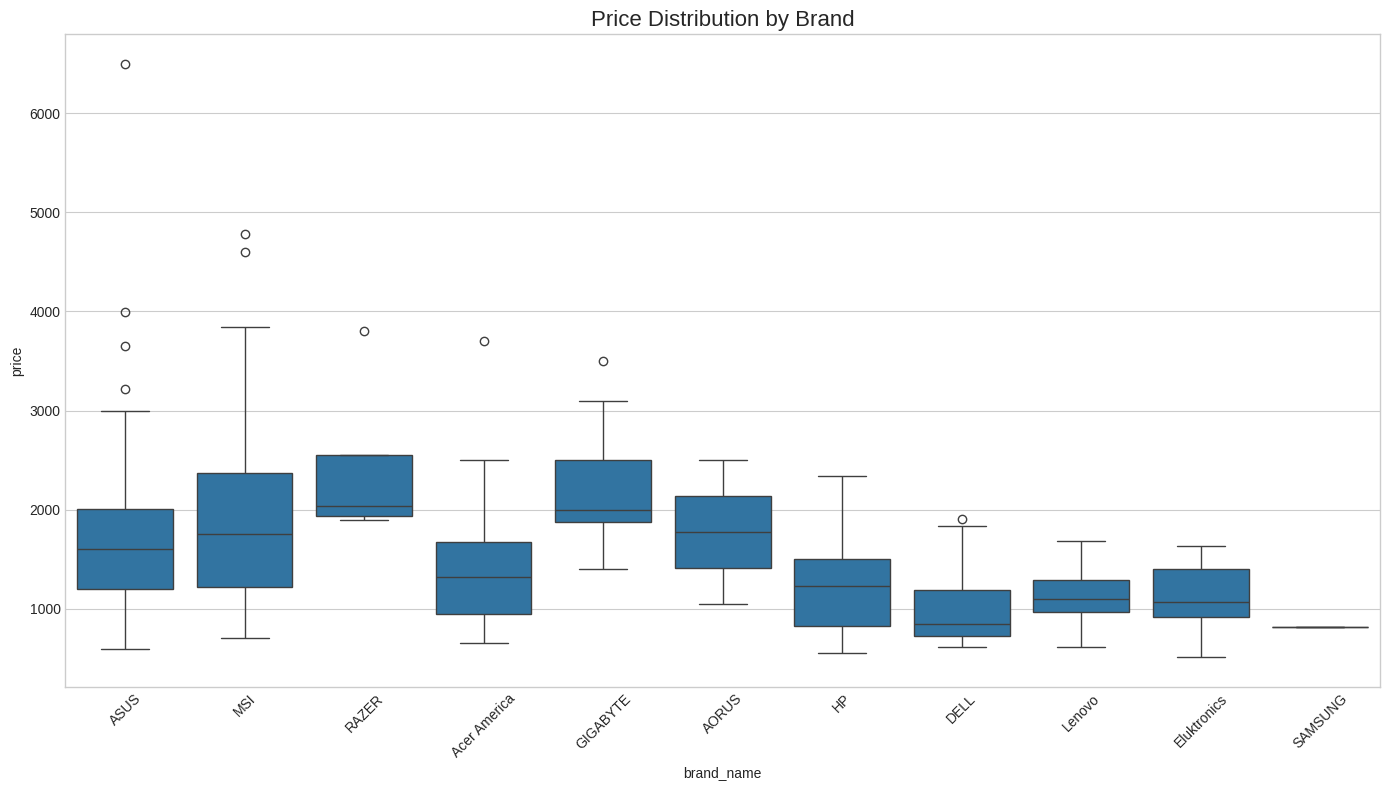

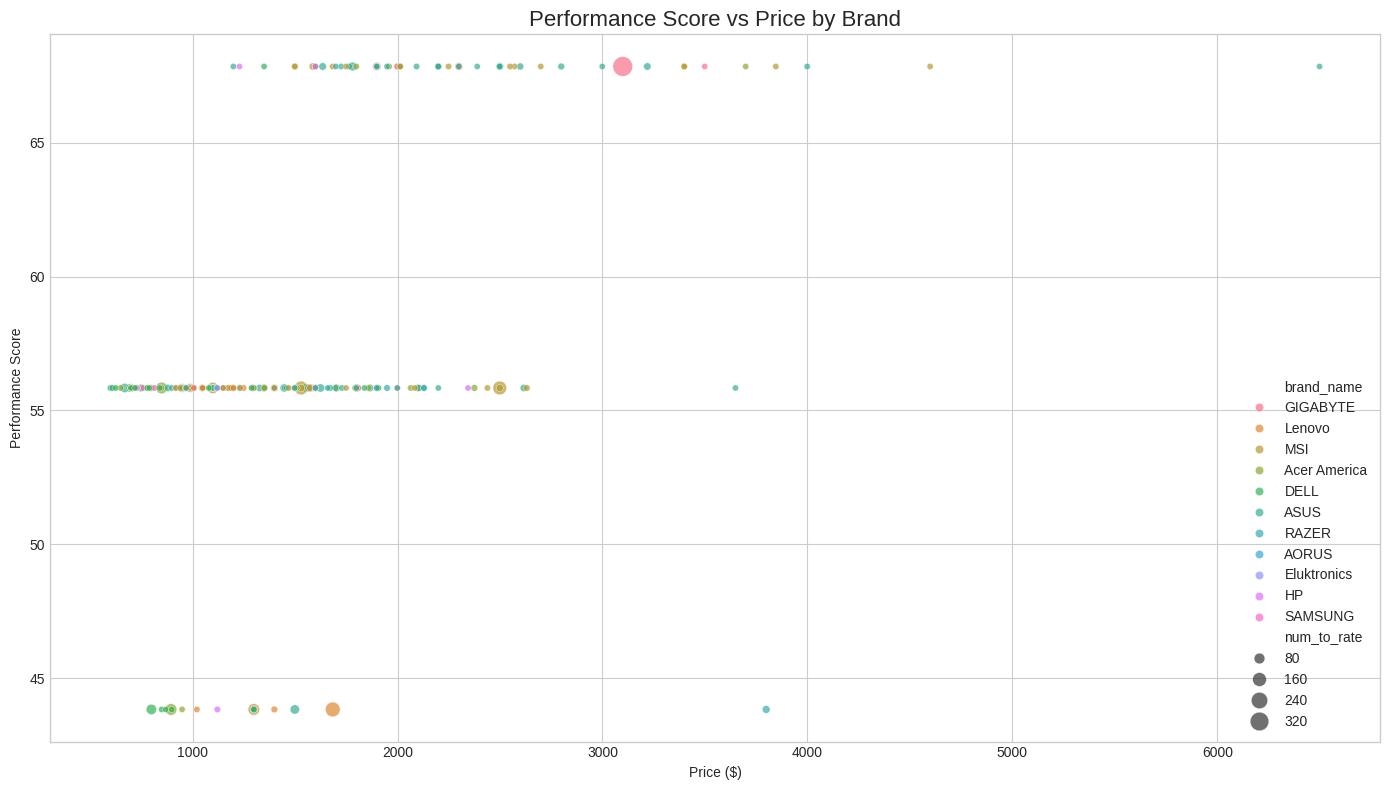

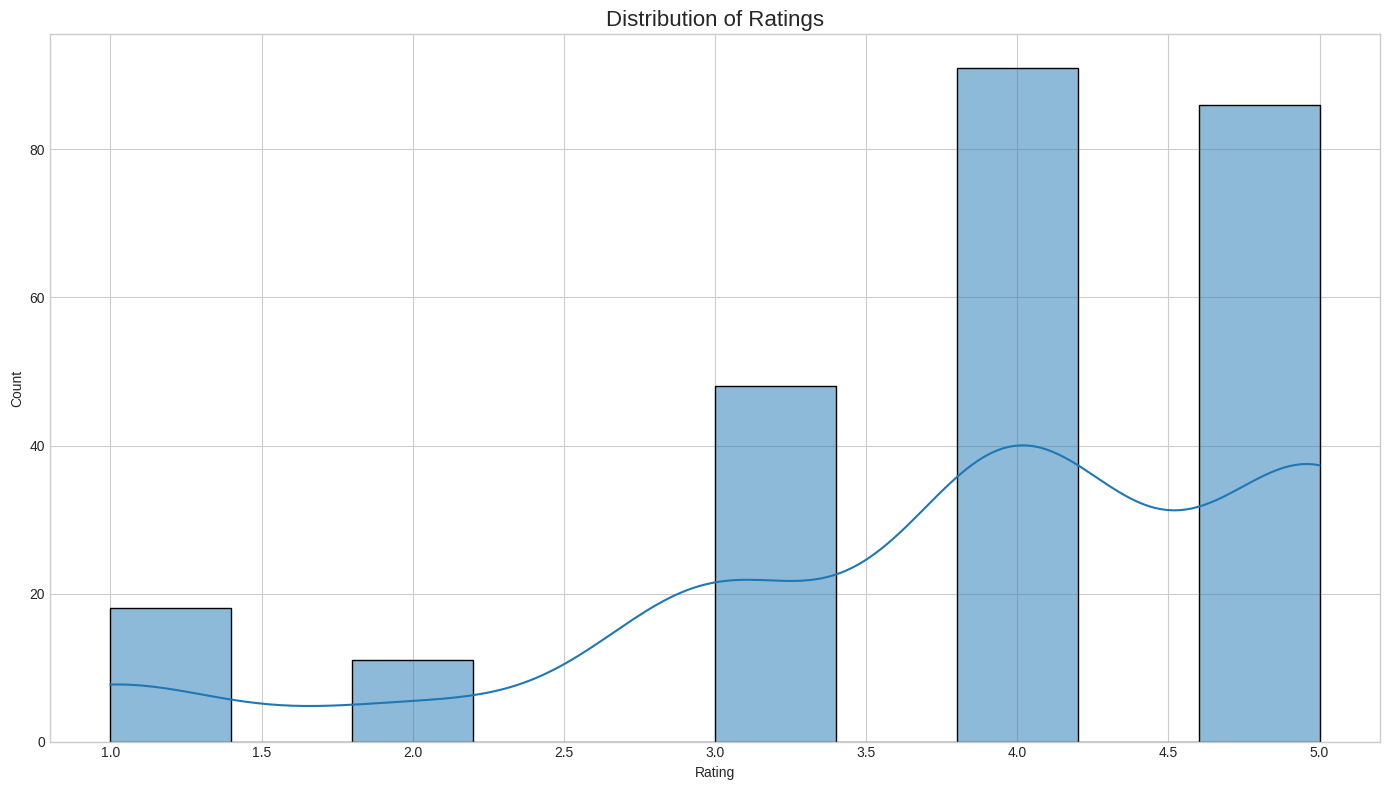

/tmp/ipykernel_166/3019709893.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_price = enhanced_products_df.groupby('price_category')[rating_col].mean().reset_index()


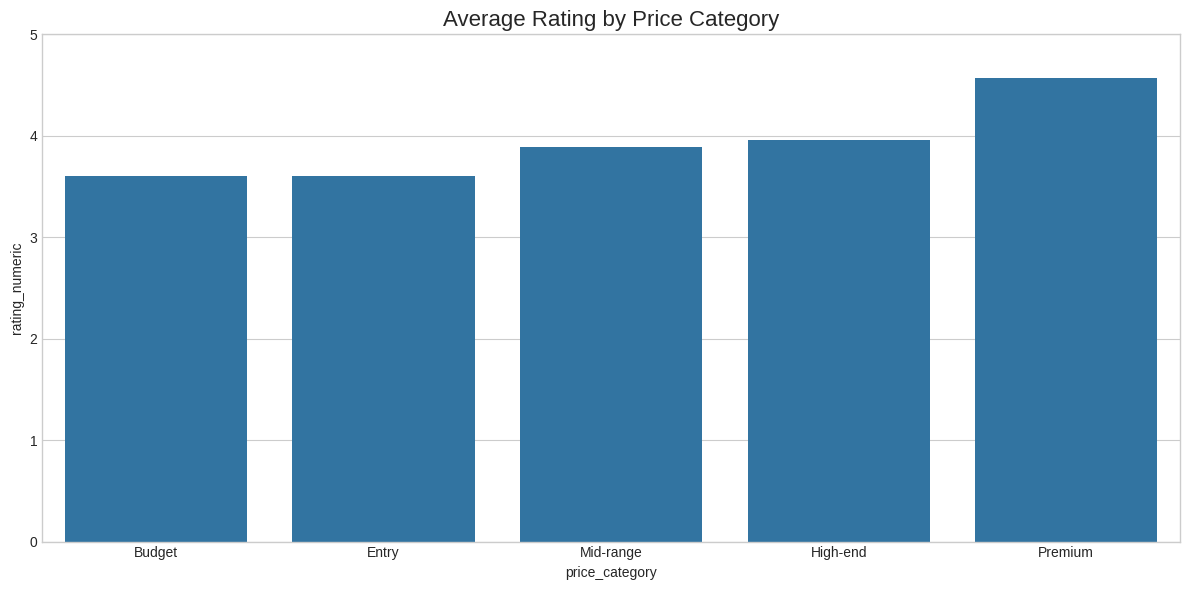

In [59]:
# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Price distribution by brand
plt.figure(figsize=(14, 8))
sns.boxplot(x='brand_name', y='price', data=enhanced_products_df.sort_values('price', ascending=False))
plt.title('Price Distribution by Brand', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance score vs price
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='price', 
    y='performance_score', 
    hue='brand_name', 
    size='num_to_rate',
    sizes=(20, 200),
    alpha=0.7,
    data=enhanced_products_df
)
plt.title('Performance Score vs Price by Brand', fontsize=16)
plt.xlabel('Price ($)')
plt.ylabel('Performance Score')
plt.tight_layout()
plt.show()

# Rating distribution
if 'rating' in enhanced_products_df.columns:
    plt.figure(figsize=(14, 8))
    if not pd.api.types.is_numeric_dtype(enhanced_products_df['rating']):
        enhanced_products_df['rating_numeric'] = pd.to_numeric(
            enhanced_products_df['rating'].str.extract(r'(\d+\.?\d*)')[0], 
            errors='coerce'
        )
        rating_col = 'rating_numeric'
    else:
        rating_col = 'rating'
    
    sns.histplot(data=enhanced_products_df, x=rating_col, bins=10, kde=True)
    plt.title('Distribution of Ratings', fontsize=16)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Average rating by price category
if 'price_category' in enhanced_products_df.columns and 'rating' in enhanced_products_df.columns:
    # Use the appropriate rating column
    if 'rating_numeric' in enhanced_products_df.columns:
        rating_col = 'rating_numeric'
    else:
        rating_col = 'rating'
    
    avg_by_price = enhanced_products_df.groupby('price_category')[rating_col].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='price_category', y=rating_col, data=avg_by_price)
    plt.title('Average Rating by Price Category', fontsize=16)
    plt.ylim(0, 5)
    plt.tight_layout()
    plt.show()

## 7. Export Processed Data

In [60]:
# Export processed data
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export enhanced products
products_output_path = f"./data/processed/processed_products_{timestamp}.csv"
enhanced_products_df.to_csv(products_output_path, index=False)
print(f"Exported processed products to: {products_output_path}")

# Export cleaned reviews
reviews_output_path = f"./data/processed/processed_reviews_{timestamp}.csv"
cleaned_reviews_df.to_csv(reviews_output_path, index=False)
print(f"Exported processed reviews to: {reviews_output_path}")


Exported processed products to: ./data/processed/processed_products_20250522_152822.csv
Exported processed reviews to: ./data/processed/processed_reviews_20250522_152822.csv
